
# Evaluación del Mejor Modelo de Optuna en MNIST (PyTorch)

Este notebook muestra cómo ejecutar Optuna, reconstruir el mejor modelo encontrado, entrenarlo sobre todo el conjunto de entrenamiento y evaluarlo en el conjunto de prueba.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

import optuna
from optuna.samplers import RandomSampler

c:\Users\Equipo\Desktop\Main\Code Projects\DL_Class\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In [2]:
# Dataset y transformaciones
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

## Definición del modelo

In [3]:
# Definición del modelo
class SimpleNet(nn.Module):
    def __init__(self, n_units, dropout_rate):
        super(SimpleNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, n_units)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(n_units, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Definición de la sintonización de hiperparámetros

In [4]:
# La función objective recibe el obejto trial y retorna alguna medida de desempeño.
# Debe incluir la definición, entrenamiento y validación del modelo.
def objective(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    # Espacio de búsqueda.
    # Dependiendo del algoritmo de muestreo se eligen:
    # a) todos los valores.
    # b) valores al azar.
    # c) valores según algún criterio de búsqueda (Bayesian Optimization)
    n_units = trial.suggest_int('n_units', 32, 256)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])

    # Definición del modelo.
    model = SimpleNet(n_units, dropout_rate).to(device)

    # Se define el optimzador de acuerdo con la búsqueda.
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Función de costo.
    criterion = nn.CrossEntropyLoss()

    # Recordar que para la búsqueda de hiperparámetros se usan 3 conjuntos: Train,
    # Validation y Test.
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    # Ciclo de entrenamiento del modelo
    model.train()
    for epoch in range(5):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    # Evaluación sobre el conjunto de validación
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)

    # Se retorna el error, así que se búsca minimizar el error. Tmabién puede ser
    # que se quiera maximizar el accuracy.
    val_accuracy = correct / total
    return 1.0 - val_accuracy


In [5]:
# Se define el objeto study encargado de realizar la búsqueda. Por defecto se
# usa un sampler = TPESampler, pero puede usarse cualquiera en este listado:
# https://optuna-readthedocs-io.translate.goog/en/stable/tutorial/10_key_features/003_efficient_optimization_algorithms.html?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es&_x_tr_pto=tc#pruning
study = optuna.create_study(direction='minimize')
# study = optuna.create_study(direction='minimize', sampler=RandomSampler())
print(f"Sampler is {study.sampler.__class__.__name__}")
study.optimize(objective, n_trials=10) #Se pasa la función objective y se define
# la cantidad máxima de iteraciones.

[I 2025-11-13 15:37:05,700] A new study created in memory with name: no-name-11ddf12d-af89-4c77-81cc-4f1d23e70d45


Sampler is TPESampler
cuda


[I 2025-11-13 15:37:17,460] Trial 0 finished with value: 0.12841666666666662 and parameters: {'n_units': 51, 'dropout_rate': 0.1875375434662574, 'learning_rate': 0.003061017502205903, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.12841666666666662.


cuda


[I 2025-11-13 15:37:28,618] Trial 1 finished with value: 0.12041666666666662 and parameters: {'n_units': 41, 'dropout_rate': 0.400058764458152, 'learning_rate': 0.007027741617260447, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.12041666666666662.


cuda


[I 2025-11-13 15:37:40,045] Trial 2 finished with value: 0.05091666666666672 and parameters: {'n_units': 106, 'dropout_rate': 0.38884628440847147, 'learning_rate': 0.0011751278894079522, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.05091666666666672.


cuda


[I 2025-11-13 15:37:51,338] Trial 3 finished with value: 0.0668333333333333 and parameters: {'n_units': 237, 'dropout_rate': 0.38853109995093804, 'learning_rate': 0.00017550412197054645, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.05091666666666672.


cuda


[I 2025-11-13 15:38:02,545] Trial 4 finished with value: 0.050583333333333313 and parameters: {'n_units': 134, 'dropout_rate': 0.4489985382602356, 'learning_rate': 0.001720471707409676, 'optimizer': 'RMSprop'}. Best is trial 4 with value: 0.050583333333333313.


cuda


[I 2025-11-13 15:38:13,953] Trial 5 finished with value: 0.07483333333333331 and parameters: {'n_units': 45, 'dropout_rate': 0.22449126975123793, 'learning_rate': 0.0025169698692691076, 'optimizer': 'Adam'}. Best is trial 4 with value: 0.050583333333333313.


cuda


[I 2025-11-13 15:38:25,247] Trial 6 finished with value: 0.04841666666666666 and parameters: {'n_units': 150, 'dropout_rate': 0.44871019207444085, 'learning_rate': 0.001998300102596006, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.04841666666666666.


cuda


[I 2025-11-13 15:38:36,712] Trial 7 finished with value: 0.07141666666666668 and parameters: {'n_units': 64, 'dropout_rate': 0.39862269685080887, 'learning_rate': 0.003599408580278272, 'optimizer': 'Adam'}. Best is trial 6 with value: 0.04841666666666666.


cuda


[I 2025-11-13 15:38:48,128] Trial 8 finished with value: 0.04425000000000001 and parameters: {'n_units': 252, 'dropout_rate': 0.42684864381485454, 'learning_rate': 0.0006178822069985012, 'optimizer': 'Adam'}. Best is trial 8 with value: 0.04425000000000001.


cuda


[I 2025-11-13 15:38:59,398] Trial 9 finished with value: 0.08250000000000002 and parameters: {'n_units': 93, 'dropout_rate': 0.45884954832012803, 'learning_rate': 0.0030812467883052194, 'optimizer': 'RMSprop'}. Best is trial 8 with value: 0.04425000000000001.


## Visualización de resultados

In [6]:
print('Mejores parámetros encontrados:')
print(study.best_params)

Mejores parámetros encontrados:
{'n_units': 252, 'dropout_rate': 0.42684864381485454, 'learning_rate': 0.0006178822069985012, 'optimizer': 'Adam'}


C:\Users\Equipo\AppData\Local\Temp\ipykernel_16884\1317441400.py:2: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

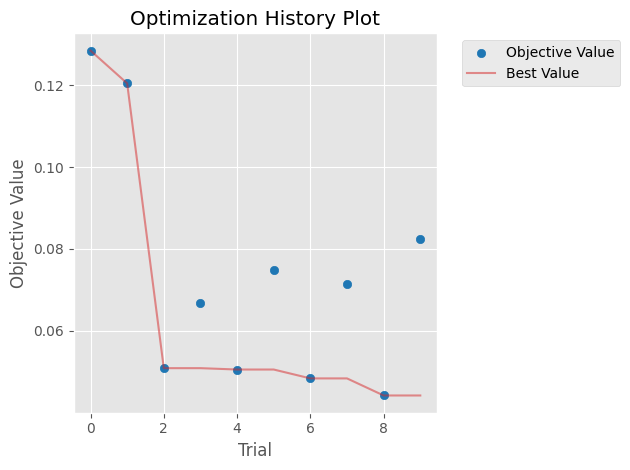

In [7]:
import optuna.visualization.matplotlib
optuna.visualization.matplotlib.plot_optimization_history(study)

In [8]:
optuna.visualization.plot_param_importances(study)

## Reentrenamiento del modelo con los mejores hiperparámetros y evaluación final sobre el conjunto de prueba.

In [9]:
# Extraer mejores hiperparámetros
best_params = study.best_params
n_units = best_params['n_units']
dropout_rate = best_params['dropout_rate']
optimizer_name = best_params['optimizer']
learning_rate = best_params['learning_rate']


In [10]:
# Reconstruir modelo final
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNet(n_units, dropout_rate).to(device)

if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_name == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss()

In [11]:
# Entrenar con todo el conjunto de entrenamiento
full_train_loader = DataLoader(dataset, batch_size=128, shuffle=True)
num_epochs = 10

model.train()
for epoch in range(num_epochs):
    for data, target in full_train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()


In [12]:

# Evaluar en el conjunto de prueba
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

model.eval()
correct = 0
total = 0
test_loss = 0.0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct / total

print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Test loss: {avg_test_loss:.4f}')


Test accuracy: 0.9728
Test loss: 0.0881


## Actividad: Búsqueda de hiperparámetros

Para la base de datos Fashion Mnist, realizar una búsqueda de hiperparámetros que incluya:

1. Número adecuado de capas.
2. Número de neuronas por capa.
3. Tamaño del lote.
4. Learning Rate.

In [13]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
class FlexibleNet(nn.Module):
    def __init__(self, layer_units, dropout_rate):
        super(FlexibleNet, self).__init__()
        layers = [nn.Flatten()]
        in_features = 28 * 28
        for u in layer_units:
            layers.append(nn.Linear(in_features, u))
            layers.append(nn.ReLU())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            in_features = u
        layers.append(nn.Linear(in_features, 10))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Objective for Optuna
def objective_fashion(trial):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Hiperparámetros a buscar
    n_layers = trial.suggest_int('n_layers', 1, 3)
    layer_units = [trial.suggest_int(f'n_units_l{i}', 32, 512, step=32) for i in range(n_layers)]
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    lr = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128, 256])

    # Construir modelo
    model = FlexibleNet(layer_units, dropout_rate).to(device)
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()

    # Split train/validation
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Entrenamiento rápido (pocas épocas para búsqueda)
    model.train()
    epochs = 5
    for epoch in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    # Evaluación en validación
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)

    val_accuracy = correct / total
    return 1.0 - val_accuracy  # minimizar


In [15]:
study_fashion = optuna.create_study(direction='minimize')
study_fashion.optimize(objective_fashion, n_trials=30)

print("Best params (FashionMNIST):", study_fashion.best_params)

[I 2025-11-13 15:42:36,281] A new study created in memory with name: no-name-697c0631-b440-424c-8278-8d8579d06d52
[I 2025-11-13 15:42:46,894] Trial 0 finished with value: 0.6203333333333334 and parameters: {'n_layers': 2, 'n_units_l0': 32, 'n_units_l1': 256, 'dropout_rate': 0.20020309784107881, 'learning_rate': 0.0005015868600622552, 'optimizer': 'SGD', 'batch_size': 256}. Best is trial 0 with value: 0.6203333333333334.
[I 2025-11-13 15:42:57,755] Trial 1 finished with value: 0.13649999999999995 and parameters: {'n_layers': 2, 'n_units_l0': 416, 'n_units_l1': 512, 'dropout_rate': 0.2646034246521484, 'learning_rate': 0.00019230115813422905, 'optimizer': 'RMSprop', 'batch_size': 256}. Best is trial 1 with value: 0.13649999999999995.
[I 2025-11-13 15:43:12,852] Trial 2 finished with value: 0.14366666666666672 and parameters: {'n_layers': 3, 'n_units_l0': 224, 'n_units_l1': 288, 'n_units_l2': 320, 'dropout_rate': 0.18417737175229643, 'learning_rate': 0.0019919200136613146, 'optimizer': 'RM

Best params (FashionMNIST): {'n_layers': 1, 'n_units_l0': 416, 'dropout_rate': 0.05941092159636977, 'learning_rate': 0.0013102332215465223, 'optimizer': 'Adam', 'batch_size': 32}


In [16]:
best = study_fashion.best_params
n_layers = best['n_layers']
best_layer_units = [best[f'n_units_l{i}'] for i in range(n_layers)]
best_dropout = best['dropout_rate']
best_lr = best['learning_rate']
best_optimizer_name = best['optimizer']
best_batch = best['batch_size']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model = FlexibleNet(best_layer_units, best_dropout).to(device)
if best_optimizer_name == 'Adam':
    final_optimizer = optim.Adam(final_model.parameters(), lr=best_lr)
elif best_optimizer_name == 'RMSprop':
    final_optimizer = optim.RMSprop(final_model.parameters(), lr=best_lr)
else:
    final_optimizer = optim.SGD(final_model.parameters(), lr=best_lr)
criterion = nn.CrossEntropyLoss()

In [17]:
full_train_loader = DataLoader(dataset, batch_size=best_batch, shuffle=True)
num_epochs_final = 10
final_model.train()
for epoch in range(num_epochs_final):
    for data, target in full_train_loader:
        data, target = data.to(device), target.to(device)
        final_optimizer.zero_grad()
        output = final_model(data)
        loss = criterion(output, target)
        loss.backward()
        final_optimizer.step()

In [18]:
test_loader = DataLoader(test_dataset, batch_size=best_batch, shuffle=False)
final_model.eval()
correct = 0
total = 0
test_loss = 0.0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = final_model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = correct / total

print(f"Final test accuracy (FashionMNIST): {test_accuracy:.4f}")
print(f"Final test loss: {avg_test_loss:.4f}")


Final test accuracy (FashionMNIST): 0.8777
Final test loss: 0.3708
